<a href="https://colab.research.google.com/github/tiwarylab/TERP/blob/main/TERP_celebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Thermodynamically Explainable Representations of AI and other blackbox Paradigms (TERP)**

**Explain Mobilenet predictions trained on celebA dataset**


---
<img src="https://raw.githubusercontent.com/shams-mehdi/TERP/main/101.png">

**References:**
<br>
*   Howard, A. G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., ... & Adam, H. (2017). Mobilenets: Efficient convolutional neural networks for mobile vision applications. arXiv preprint arXiv:1704.04861.
*   Liu, Z., Luo, P., Wang, X., & Tang, X. (2018). Large-scale celebfaces attributes (celeba) dataset. Retrieved August, 15(2018), 11.

In [1]:
# @title Step 0: Load libraries & clone github repository
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision.transforms as transforms
from os.path import exists
from PIL import Image
import torch.nn.functional as F
from skimage.segmentation import slic, mark_boundaries, quickshift
from tqdm import tqdm
import matplotlib.ticker as ticker
from pathlib import Path
import glob
import subprocess
import copy

!npx degit -f tiwarylab/TERP

npx: installed 1 in 2.653s
> destination directory is not empty. Using --force, continuing
> cloned tiwarylab/TERP#HEAD


In [2]:
#@title Step 1: Load trained Mobilenets model

'''
All mobilenet layers are followed by batch normalization and then the
activation function. Creating 28 layer MobileNet architecture below (
counting depthwise, pointwise convolutions separately).
'''
class MISH_activation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x*(torch.tanh(F.softplus(x)))


def first_layer_full_activation(in_channels, out_channels, stride):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                        nn.BatchNorm2d(out_channels),
                        MISH_activation())

def depth_point_wise_convolution(in_channels, out_channels, stride):
    return nn.Sequential(nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False),
                        nn.BatchNorm2d(in_channels),
                        MISH_activation(),
                        nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
                        nn.BatchNorm2d(out_channels),
                        MISH_activation())

class MobileNet_model(nn.Module):
    def __init__(self):
        super(MobileNet_model, self).__init__()
        self.features = nn.Sequential(
            first_layer_full_activation(  3,  32, 2),
            depth_point_wise_convolution( 32,  64, 1),
            depth_point_wise_convolution( 64, 128, 2),
            depth_point_wise_convolution(128, 128, 1),
            depth_point_wise_convolution(128, 256, 2),
            depth_point_wise_convolution(256, 256, 1),
            depth_point_wise_convolution(256, 512, 2),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 1024, 2),
            depth_point_wise_convolution(1024, 1024, 1),
            nn.AvgPool2d(7),)
        self.fc = nn.Linear(1024, num_labels)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

transform = transforms.Compose([transforms.Resize((267,327)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

attributes = ['5_o_Clock_Shadow', 'Bald', 'Bangs', 'Blond_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necktie']
num_labels = len(attributes)
trained_model_path = 'celebA/MobileNets_model.pth'
model = torch.load(trained_model_path)
model.eval()
print("MobileNet model loaded successfully.")

MobileNet model loaded successfully.


**Recommendations for step 2:**

*   Choose one out of the four images highlighted in the paper or,
*   Choose one out of the hundred samples from celebA test set using the slider

In [34]:
#@title Step 2: Select facial image
smiling = True #@param {type:"boolean"}
goatee = False #@param {type:"boolean"}
necktie = False #@param {type:"boolean"}
blonde = False #@param {type:"boolean"}
select_other = False #@param {type:"boolean"}
other = 44 #@param {type:"slider", min:0, max:99, step:1}

if smiling==True:
  sample_name = "celebA/smiling.png"

if goatee==True:
  sample_name = "celebA/goatee.png"

if necktie==True:
  sample_name = "celebA/necktie.png"

if blonde==True:
  sample_name = "celebA/blonde.png"

if select_other==True:
  sample_name = "celebA/other_samples/1812" + str(other) + ".png"

if exists(sample_name) == True:
  fn = sample_name
  print('File exists. Selected file: ', fn)
else:
  print("File doesn't exist!")

File exists. Selected file:  celebA/smiling.png


Detected attributes ::

Attribute index: 11, attribute:Mouth_Slightly_Open
Attribute index: 13, attribute:No_Beard
Attribute index: 17, attribute:Smiling


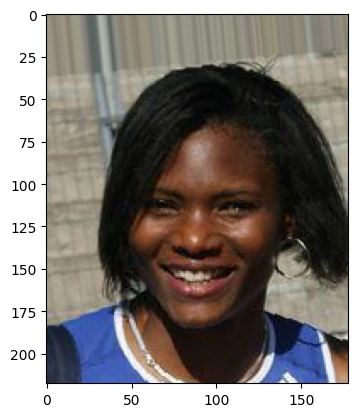

In [35]:
#@title Step 3: Pass image through the MobileNets model to obtain attribute predictions

plt.imshow(Image.open(fn))
image_tensor = transform(Image.open(fn))
image = torch.unsqueeze(image_tensor, 0)
image = image.to('cuda')
pred_proba = model(image)
classification = (pred_proba>0.5).cpu().numpy()[0]

true_attributes= [i for i, x in enumerate(classification) if x]
false_attributes = [i for i, x in enumerate(classification) if x==False]
print("Detected attributes ::\n")
for i in true_attributes:
  print("Attribute index: " + str(i) + ", attribute:" + attributes[i])


**Recommendations for step 4:**
*   Use the **compactness slider** to tune SLIC segmentation algorithm
*   Minimum compactness: segmentation according to the color space
*   Maximum compactness: segmentation according to the geometric space

Number of super-pixels ::  48


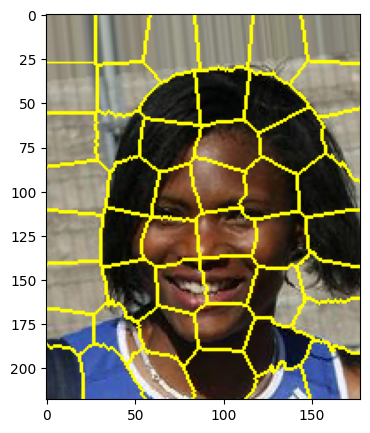

In [45]:
#@title Step 4: Define super pixels using SLIC segmentation algorithm (manually defined super-pixels/segmentation will also work)
n_segments = 50 #@param {type:"integer"}
compactness = 90 #@param {type:"slider", min:1, max:120, step:1}
from skimage.util import img_as_float
from skimage import io

fig,ax = plt.subplots(figsize=(5, 5))
image = Image.open(sample_name)
segments = slic(image,n_segments=n_segments,compactness=compactness)-1
ax.imshow(mark_boundaries(img_as_float(io.imread(fn)), segments))
np.save('image_segments.npy', segments)
print('Number of super-pixels :: ', np.unique(segments).shape[0])

In [46]:
#@title Step 5: Run TERP
neighborhood_size = 5000 #@param {type:"integer"}
explain_attribute =  17#@param {type:"integer"}
random_seed =  0#@param {type:"integer"}
batch_size = 64
np.random.seed(random_seed)
progress_bar = True
####################################################
## Generate neighborhood
command_1 = 'python TERP_neighborhood_generator.py -seed ' + str(random_seed) + ' --progress_bar -input_image ' + sample_name + ' -num_samples ' + str(neighborhood_size) + ' -image_segments_loader image_segments.npy'
print('Executing command :: ', command_1)
!$command_1
####################################################
## Get predictions for the generated neighborhood
print("Selected attribute: " + attributes[explain_attribute])

def make_prediction(specific_image, explain_attribute):
  image_tensor = transform(specific_image)
  image = torch.unsqueeze(image_tensor, 0)
  image = image.to('cuda')
  pred_proba = model(image)
  classification = (pred_proba>0.5).cpu().numpy()
  return pred_proba[:, explain_attribute]

imgs = []
if explain_attribute not in true_attributes:
  print("Invalid attribute selected!")
  explain_attribute = -9

else:
  for name in sorted(glob.glob('DATA/perturbed_images/*.png')):
      imgs.append(name)
  image = Image.open(imgs[0])
  segments = np.load('image_segments.npy')
  rgb_image = np.array(image.getdata()).reshape((image.size[1], image.size[0],3))
  fudged_image = rgb_image.copy()

  n_features = np.unique(segments).shape[0]

  num_samples = copy.deepcopy(neighborhood_size)
  predict_a = np.zeros((num_samples))
  img_list = []
  print("Fetching predictions from MobileNet (obscure model)!")
  num_samples = tqdm(np.arange(num_samples)) if progress_bar else num_samples
  i = 0
  for sample in num_samples:
      predict_a[sample] = make_prediction(Image.open(imgs[sample]).convert('RGB'), explain_attribute)
      img_list.append(Image.open(imgs[sample]))
      i+=1

  predict_b = (predict_a > 0.5).astype(np.int_)
  print("Neighborhood size: ", predict_a.shape[0], "Number of positive samples: ", np.sum(predict_b))

np.save('DATA/prediction_neighborhood.npy', predict_a)
####################################################
## Run initial round of linear regression to discard irrelevant features
command_2 = 'python TERP_optimizer_01.py -TERP_input DATA/TERP_image.npy -blackbox_prediction DATA/prediction_neighborhood.npy'
print('Executing command :: ', command_2)
!$command_2
####################################################
## Generate neighborhood for round 2/forward feature selection
command_3 = 'python TERP_neighborhood_generator.py -seed ' + str(random_seed) + ' --progress_bar -input_image ' + sample_name + ' -num_samples ' + str(neighborhood_size) + ' -selected_features TERP_results/selected_features.npy -image_segments_loader image_segments.npy'
print('Executing command :: ', command_3)
!$command_3
####################################################
## Get predictions for the generated neighborhood for round 2

def make_prediction(specific_image, explain_attribute):
  image_tensor = transform(specific_image)
  image = torch.unsqueeze(image_tensor, 0)
  image = image.to('cuda')
  pred_proba = model(image)
  classification = (pred_proba>0.5).cpu().numpy()
  return pred_proba[:, explain_attribute]

imgs = []
if explain_attribute not in true_attributes:
  print("Invalid attribute selected!")
  explain_attribute = -9

else:
  for name in sorted(glob.glob('DATA_2/perturbed_images/*.png')):
      imgs.append(name)
  image = Image.open(imgs[0])
  segments = np.load('image_segments.npy')
  rgb_image = np.array(image.getdata()).reshape((image.size[1], image.size[0],3))
  fudged_image = rgb_image.copy()

  n_features = np.unique(segments).shape[0]


  predict_a = np.zeros((neighborhood_size))
  img_list = []
  print("Fetching predictions from MobileNet (obscure model)!")
  num_samples = tqdm(np.arange(neighborhood_size)) if progress_bar==True else neighborhood_size
  i = 0
  for sample in num_samples:
      predict_a[sample] = make_prediction(Image.open(imgs[sample]).convert('RGB'), explain_attribute)
      img_list.append(Image.open(imgs[sample]))
      i+=1

  predict_b = (predict_a > 0.5).astype(np.int_)
  print("Neighborhood size: ", predict_a.shape[0], "Number of positive samples: ", np.sum(predict_b))

np.save('DATA_2/prediction_neighborhood_2.npy', predict_a)
###################################################
command_4 = 'python TERP_optimizer_02.py -TERP_input DATA_2/TERP_image.npy -blackbox_prediction DATA_2/prediction_neighborhood_2.npy -selected_features TERP_results/selected_features.npy --save_all'
print('Executing command :: ', command_4)
!$command_4
###################################################

Executing command ::  python TERP_neighborhood_generator.py -seed 0 --progress_bar -input_image celebA/smiling.png -num_samples 5000 -image_segments_loader image_segments.npy
>>> Image data provided...
>>> Generating data...
100% 5000/5000 [00:48<00:00, 102.30it/s]
>>> Data generation complete!
Files saved in :::  /content/DATA
Selected attribute: Smiling
Fetching predictions from MobileNet (obscure model)!


100%|██████████| 5000/5000 [00:49<00:00, 100.78it/s]


Neighborhood size:  5000 Number of positive samples:  3366
Executing command ::  python TERP_optimizer_01.py -TERP_input DATA/TERP_image.npy -blackbox_prediction DATA/prediction_neighborhood.npy
----------------------------------------------------------------------------------------------------
10-24-23 02:01:52 initialization  INFO     Starting TERP...
----------------------------------------------------------------------------------------------------
10-24-23 02:01:52 initialization  INFO     Input data read successful ...
10-24-23 02:01:52 initialization  WARNING  explain_class not provided, defaulting to class with maximum predictiion probability :: 0
10-24-23 02:01:52 initialization  WARNING  Cutoff not provided. Defaulting to :: 25
10-24-23 02:01:52 initialization  INFO     No distance flag provided. Performing 1-d LDA projection to compute similarity measure!
10-24-23 02:01:52 initialization  WARNING  Top 25 features selected with weight coverage :: 0.9544757927219303!!
10-24-23

100%|██████████| 5000/5000 [00:45<00:00, 109.46it/s]


Neighborhood size:  5000 Number of positive samples:  3337
Executing command ::  python TERP_optimizer_02.py -TERP_input DATA_2/TERP_image.npy -blackbox_prediction DATA_2/prediction_neighborhood_2.npy -selected_features TERP_results/selected_features.npy --save_all
----------------------------------------------------------------------------------------------------
10-24-23 02:03:17 initialization  INFO     Starting TERP...
----------------------------------------------------------------------------------------------------
10-24-23 02:03:17 initialization  INFO     Input data read successful ...
10-24-23 02:03:17 initialization  INFO     All files will be saved!
10-24-23 02:03:17 initialization  WARNING  explain_class not provided, defaulting to class with maximum predictiion probability :: 0
10-24-23 02:03:17 initialization  INFO     No distance flag provided. Performing 1-d LDA projection to compute similarity measure!
10-24-23 02:03:17 initialization  INFO     Feature selection resul

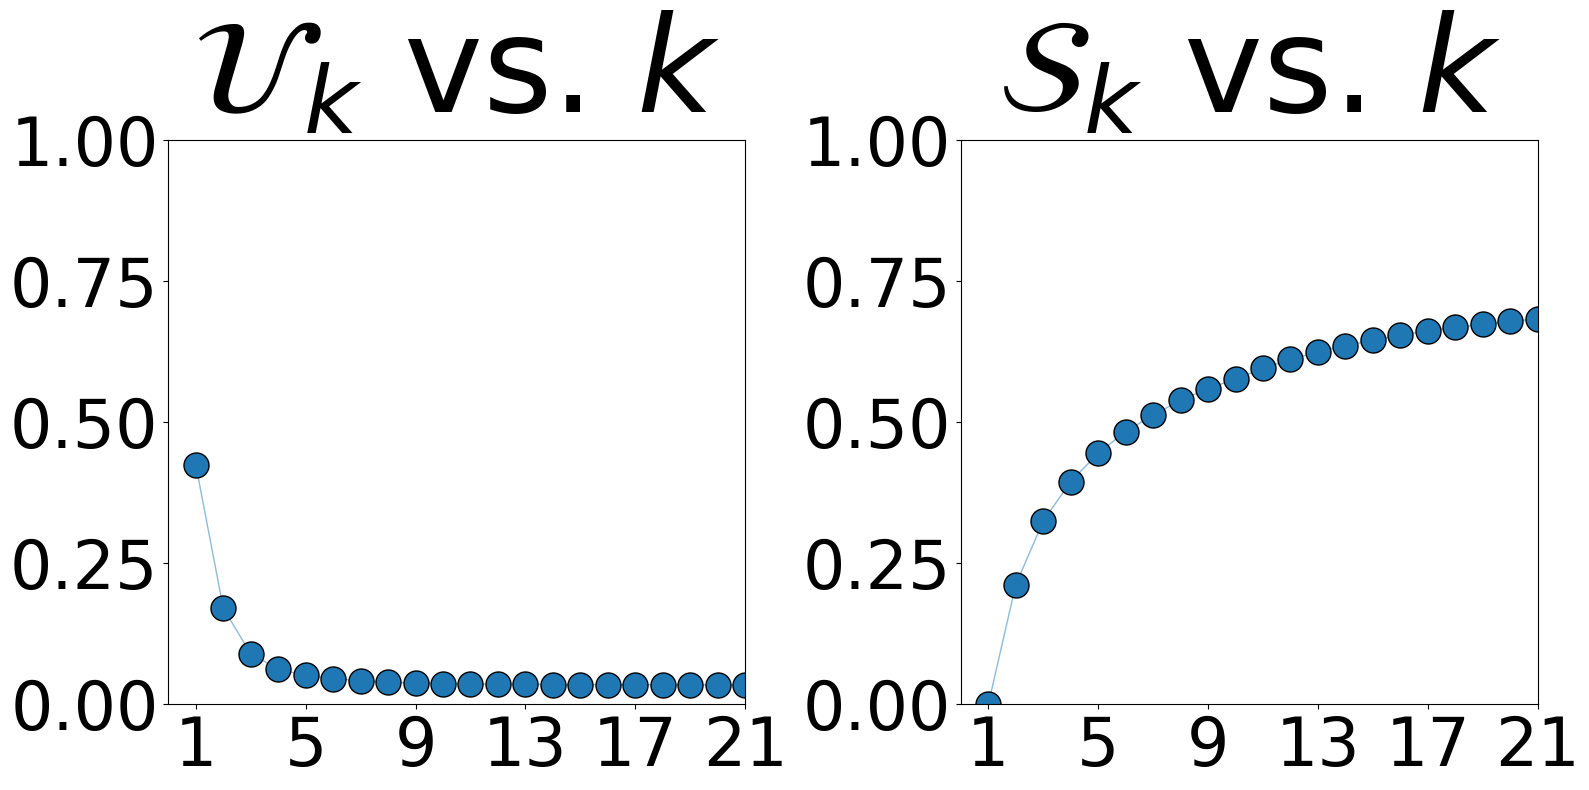

In [47]:
# @title Plot unfaithfulness and interpretation entropy as a function of number of features in the analyzed models (k_max limits visualization along X axis)
k_max = 20 # @param {type:"integer"}
U = np.load('TERP_results_2/unfaithfulness_scores_final.npy')
S = np.load('TERP_results_2/interpretation_entropy_final.npy')

fig, ax = plt.subplots(1,2, figsize = (16,8))


ax[0].plot(U, color = 'tab:blue', lw = 1, alpha = 0.5)

ax[0].plot(U,'o', markersize = 18, markeredgecolor = 'k', label = r'$\mathcal{U}_k$')
ax[0].set_ylim(0,1)
ax[0].set_title(r'$\mathcal{U}_k$ vs. $k$', fontsize = 96)

ax[0].tick_params(axis='both', which='major', labelsize=48)
ax[0].tick_params(axis='both', which='minor', labelsize=8)
ax[0].set_xticks(np.arange(U.shape[0])[::int(k_max/5)])
ax[0].set_xlim(-1,k_max)
ax[0].set_xticklabels(np.arange(U.shape[0])[::int(k_max/5)]+1)

ax[1].plot(S, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[1].plot(S,'o', markersize = 18, markeredgecolor = 'k', label = r'$\mathcal{S}_k$')
ax[1].set_ylim(0,1)
ax[1].set_title(r'$\mathcal{S}_k$ vs. $k$', fontsize = 96)

ax[1].tick_params(axis='both', which='major', labelsize=48)
ax[1].tick_params(axis='both', which='minor', labelsize=8)
ax[1].set_xticks(np.arange(S.shape[0])[::int(k_max/5)])
ax[1].set_xlim(-1,k_max)
ax[1].set_xticklabels(np.arange(S.shape[0])[::int(k_max/5)]+1)
fig.tight_layout()

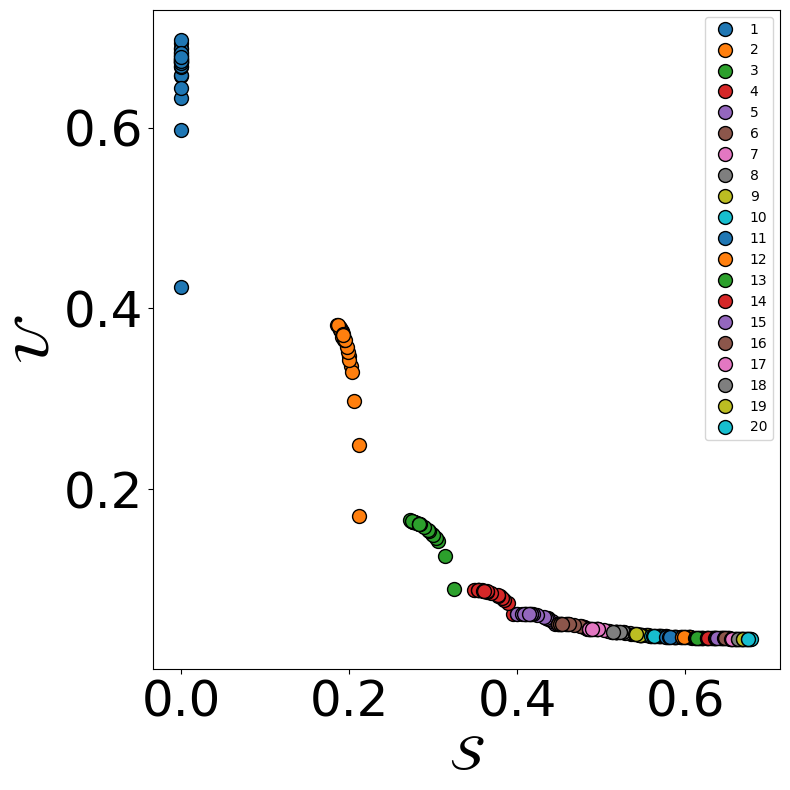

In [48]:
# @title Plot unfaithfulness vs. interpretation entropy for all constructed models i.e, including all feature combinations for the same k (k_max limits visualization along X axis, colors represent number of features in a model)
k_max = 20 # @param {type:"integer"}
fig, ax = plt.subplots(figsize = (8,8))
for i in range(k_max):
  S = np.load('TERP_results_2/' + str(i+1) + '_interpretation_entropy.npy', allow_pickle=True)
  U = np.load('TERP_results_2/' + str(i+1) + '_unfaithfulness_scores.npy', allow_pickle=True)
  ax.plot(S,U,'o', markersize = 10, markeredgecolor = 'k', label = str(i+1))

ax.set_xlabel(r'$\mathcal{S}$', fontsize = 36)
ax.set_ylabel(r'$\mathcal{U}$', fontsize = 36)
ax.tick_params(axis='both', which='major', labelsize=36)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.legend()
fig.tight_layout()

Most stable model at k ::  3  at temperature ::        0.55


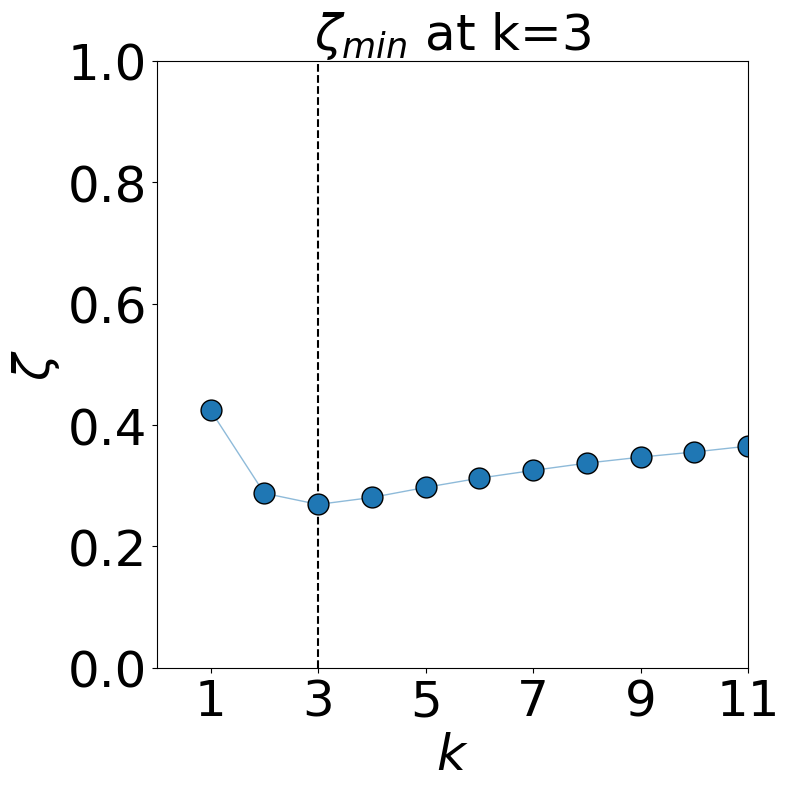

In [49]:
# @title Plot interpretability score at a stable temperature. Highlight most stable model (k_max limits visualization along X axis)
k_max = 10 # @param {type:"integer"}

U = np.load('TERP_results_2/unfaithfulness_scores_final.npy')
S = np.load('TERP_results_2/interpretation_entropy_final.npy')
T = np.load('TERP_results_2/charac_theta.npy')
T_range = np.load('TERP_results_2/range_theta.npy')

stable_model = np.argmin(T_range) + 3
stable_T = (T[stable_model - 2] + T[stable_model - 1])/2

print('Most stable model at k :: ', stable_model, ' at temperature :: ', "{:10.2f}".format(stable_T))

fig, ax = plt.subplots(figsize = (8,8))
ax.axvline(stable_model-1, linestyle = '--', color = 'k')
ax.plot(stable_T*S+U, color = 'tab:blue', lw = 1, alpha = 0.5)
ax.plot(stable_T*S+U,'o', markersize = 15, markeredgecolor = 'k', label = r'$\zeta_k$')

ax.set_ylim(0,1)
ax.set_ylabel(r'$\zeta$', fontsize = 36)
ax.set_xlabel(r'$k$', fontsize = 36)
ax.tick_params(axis='both', which='major', labelsize=36)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xticks(np.arange(U.shape[0])[::int(k_max/5)])
ax.set_xlim(-1,k_max)
ax.set_xticklabels(np.arange(U.shape[0])[::int(k_max/5)]+1)
ax.set_title(r'$\zeta_{min}$ at k=' + str(stable_model), fontsize = 36)
fig.tight_layout()

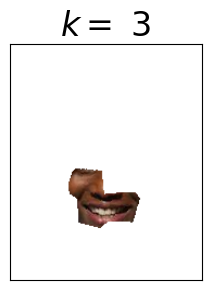

In [50]:
#@title Visualize optimal interpretation identified by TERP for Mobilenets prediction
image = Image.open(sample_name)
best_coefficients = np.load('TERP_results_2/feature_coefficients_final.npy')[stable_model-1,:]
fig, ax = plt.subplots(figsize = (3,3))
segments = np.load('image_segments.npy')

coef_mat = np.array(image.getdata()).reshape((image.size[1], image.size[0],3))
for i in range(segments.shape[0]):
    for j in range(segments.shape[1]):
        x = int(segments[i,j])
        if best_coefficients[x] == 0:
            coef_mat[i,j,0] = 255
            coef_mat[i,j,1] = 255
            coef_mat[i,j,2] = 255

ax.imshow(coef_mat, cmap=plt.cm.viridis, alpha=1.0, interpolation='bilinear')
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.set_title('$k=$ ' + str(stable_model), fontsize = 24)
fig.tight_layout()